# LSST SRD Redshift Distributions and Tomographic Binning
Use this notebook to generate the LSST SRD* redshift distributions (source and lens galaxy samples ofr appropriate LSST epochs) and to perform the tomographic binning of those samples.

*SRD stands for [Science Requirements Document](https://arxiv.org/abs/1809.01669)

In [1]:
from binning import Binning
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
from srd_redshift_distributions import SRDRedshiftDistributions

## Note on the SRD redshift distributions
The overall redshift distribution of galaxies for LSST is a Smail-type parametrisation of the form:


\begin{equation}
N (z) = \left( \frac{z}{z_0}  \right) ^\beta \exp \left[ - \left( \frac{z}{z_0}  \right) ^\alpha\right] ,
\end{equation}
where $z$ is the redshift, $z_0$ is the pivot redshift, and $\alpha$ and $\beta$ the power law indices. The pivot redshfit and power law indices have different values for lens and source galaxies and for forecast years. These values are stored in the parameters.yaml file and the details can be found in the [LSST DESC Science Requirement Document (SRD)](https://arxiv.org/abs/1809.01669)

The function `get_redshfit_distribution()` from the `SRDRedshiftDistributions` class will output the redshift distribution. The redshift distribution will be normalised by default. This can be omitted by setting the normalisation argument to False. 
There is also a default setting to automatically save the redshfit range and the redshift distribution to a .csv file. If you do not wish to export the result to file, change the argument save_file to False.

## Generate the redshift distributions

In [2]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.0, 3.5, 500)
forecast_years = ["1", "10"]  # LSST forecasting epochs

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


# Plot LSST Lens and Source Sample Distributions

In [3]:
# Set global line width and font sizes
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 15

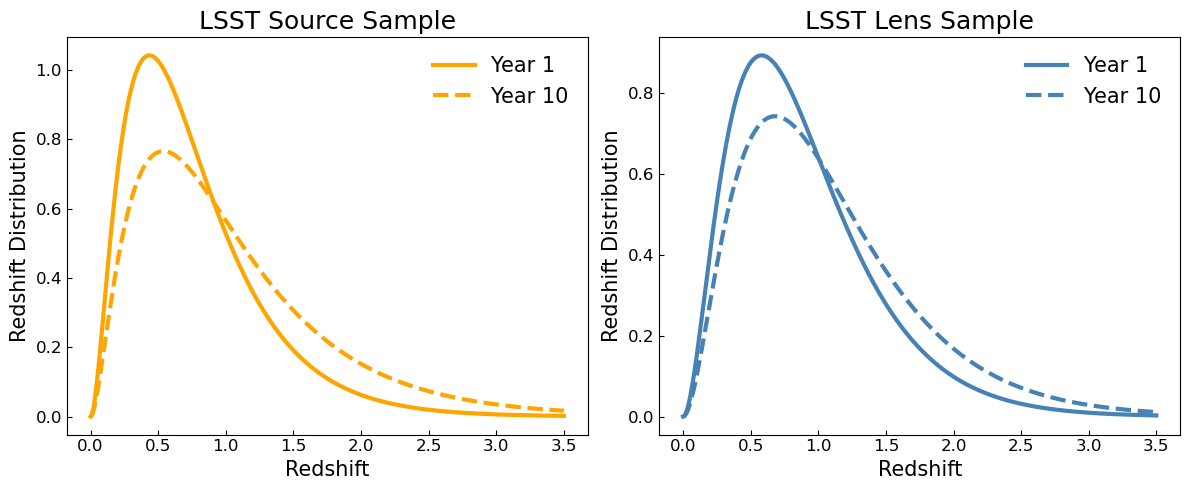

In [4]:
# Define the colors and sample types
colors = {'sources': 'orange',
          'lenses': 'steelblue'}
sample_types = ['sources', 'lenses']
titles = {'sources': 'LSST Source Sample',
          'lenses': 'LSST Lens Sample'}

# Create 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loop through sample types to create the plots
for ax, sample_type in zip(axs, sample_types):
    ax.plot(redshift_range, redshift_distribution[sample_type]['1'], label='Year 1', linestyle='-', color=colors[sample_type])
    ax.plot(redshift_range, redshift_distribution[sample_type]['10'], label='Year 10', linestyle='--', color=colors[sample_type])
    ax.set_title(titles[sample_type])
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Redshift Distribution')
    ax.tick_params(direction='in')
    ax.legend(frameon=False)

# Show the plot
plt.tight_layout()
plt.show()


## Perform the binning procedure
The code will automatically slice the redshift distribution into appropriate bins, depending on the galaxy sample (lens or source) and forecast year (1 or 10).

The output (bins) will be normalised by default and output is a dictionary. The normalisation can be skipped by setting normalised argument to false.
Functions `source_bins()` and `lens_bins()` from the `Binning` class can also autmatically save the results as a .csv file. The first column will be the redshfit interval. Bins will be in the other columns with the dictionary keys as column headers. If you do not wish to save the file as a .csv, simply set the save_file argument to false.

In [5]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
param_file = "parameters/lsst_desc_with_outliers_parameters.yaml"
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = Binning(param_file,
                                    redshift_range,
                                    redshift_distribution["sources"][year],
                                    year).source_bins(normalised=True,
                                                      save_file=False)
    bins["lenses"][year] = Binning(param_file,
                                   redshift_range, 
                                   redshift_distribution["lenses"][year],
                                   year).lens_bins(normalised=True,
                                                   save_file=False)



## Plot the Tomographic Bins
Plot the results to inspect visually.

In [6]:
# Define colors for plots
lens_colors = {
    "1": cmr.take_cmap_colors('cmr.freeze',
                              len(bins["lenses"]["1"]), 
                              cmap_range=(0.2, 0.85), 
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.freeze', len(bins["lenses"]["10"]), cmap_range=(0.2, 0.85), return_fmt='hex')
}

source_colors = {
    "1": cmr.take_cmap_colors('cmr.ember', 
                              len(bins["sources"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.ember',
                               len(bins["sources"]["10"]),
                               cmap_range=(0.2, 0.85),
                               return_fmt='hex')
}

### Lens sample bins

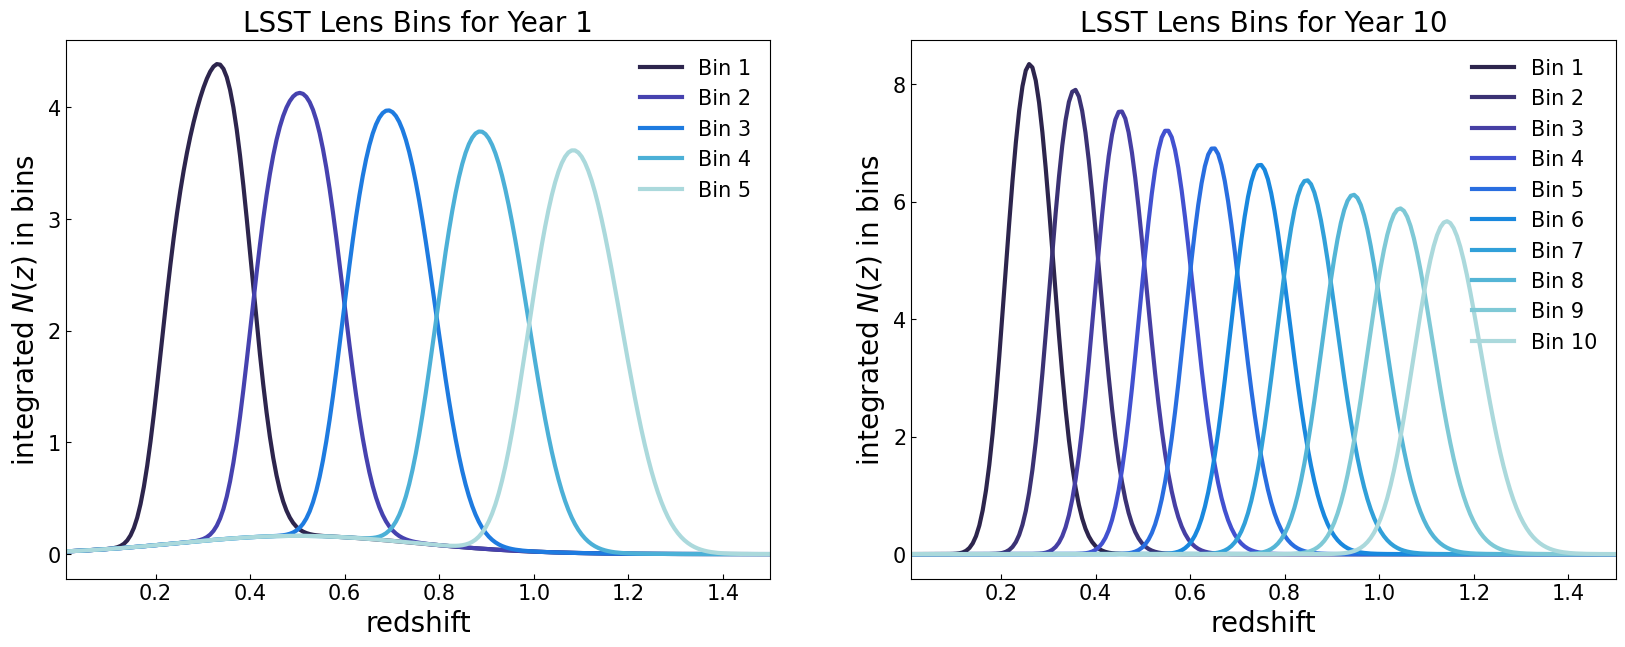

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
        ax.plot(redshift_range,
                data, 
                label=f"Bin {key+1}",
                color=lens_colors[year][bin_idx])
        ax.set_xlim(0.01, 1.5)
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

### Source sample bins

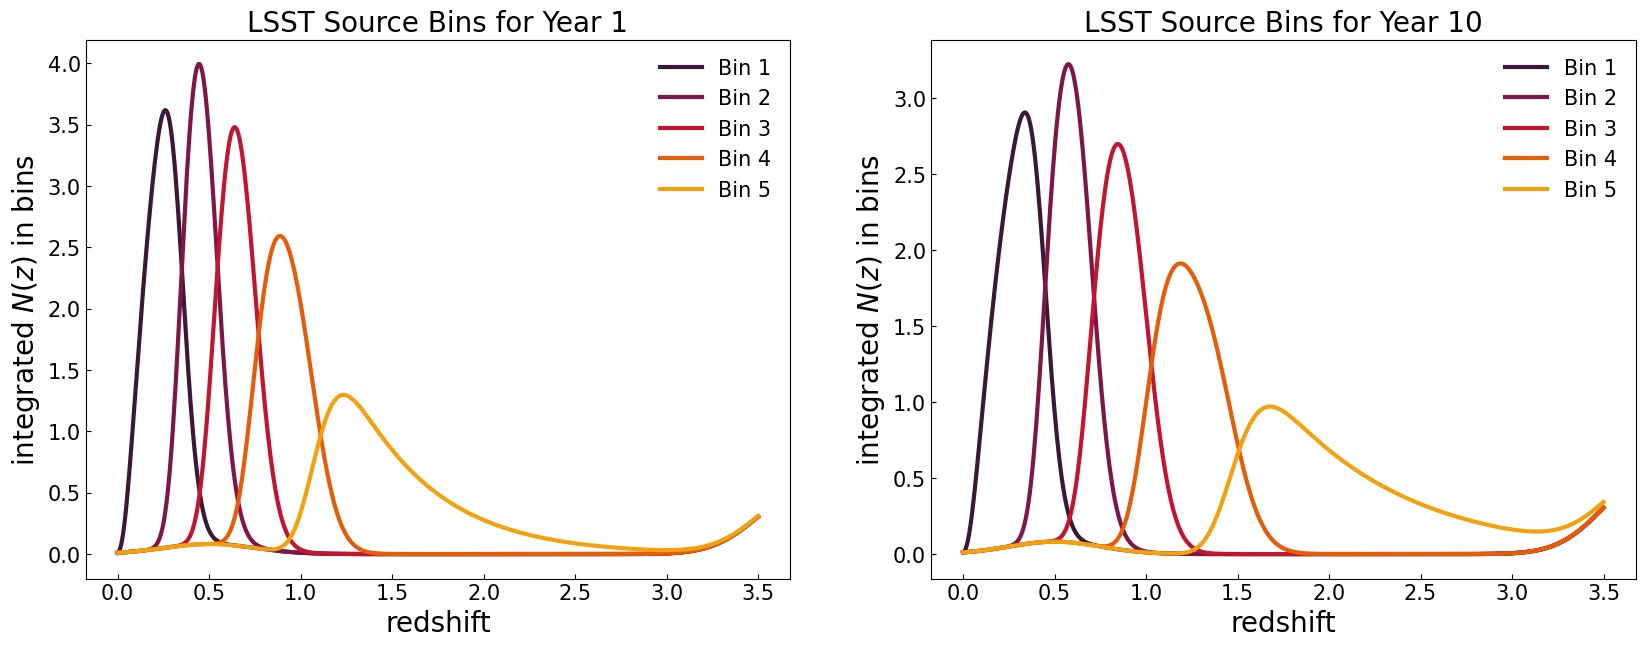

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
        ax.plot(redshift_range,
                data, 
                label=f"Bin {key+1}",
                color=source_colors[year][bin_idx])
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

## Get Bin Centers
Binning class has a method that allows to get the bin centers for a given binning scheme.
 The method returns a dictionary with the bin centers for each binning scheme ("sources" and "lenses"). 
 You can also save the bin centers as a .npy file by setting the save_file argument to true.
 **Note** that when you initialise the Binning class for a given forecast year, the output will be the bin centers for that forecast year.
 If you wish to obtain the bin centers for a different forecast year, you will need to initialise the Binning class again with the appropriate forecast year.
    The bin centers are rounded to 2 decimal places by default. You can change this by setting the round argument to a positive integer.
 

In [10]:
bin_centers_y1 = Binning(param_file,
                         redshift_range, 
                         redshift_distribution["sources"]["1"],
                         "1").get_bin_centers(save_file=False, decimal_places=2)

bin_centers_y10 = Binning(param_file,
                          redshift_range, 
                          redshift_distribution["sources"]["10"],
                          "10").get_bin_centers(save_file=False, decimal_places=2)

print(bin_centers_y1.keys())
print(bin_centers_y10.keys())
print(f"bin centers for sources year 1: {bin_centers_y1['sources']}, \n bin centers for lenses year 1: {bin_centers_y1['lenses']}")
print(f"bin centers for sources year 10: {bin_centers_y10['sources']}, \n bin centers for lenses year 10: {bin_centers_y10['lenses']}")



dict_keys(['sources', 'lenses'])
dict_keys(['sources', 'lenses'])
bin centers for sources year 1: [0.26, 0.44, 0.64, 0.89, 1.23], 
 bin centers for lenses year 1: [0.32, 0.49, 0.69, 0.88, 1.08]
bin centers for sources year 10: [0.34, 0.58, 0.85, 1.19, 1.68], 
 bin centers for lenses year 10: [0.26, 0.35, 0.45, 0.55, 0.65, 0.74, 0.84, 0.95, 1.05, 1.14]
